<a href="https://colab.research.google.com/github/Wassy4/Machine-Learning-Data-Analysis/blob/main/Machine_Learning_Model_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Summary**

I analyzed credit card transaction data to predict fraudulent activity and evaluated three machine learning models based on their AUROC and F1 scores. The dataset consists of 641,914 credit card transactions with 29 features.

```
Dataset Attribute Information:
1.   Account Number
2.   Customer ID
3.   Credit Limit
4.   Available Money
5.   Transaction Date and Time
6.   Transaction Amount
7.   Merchant Name
8.   Acquired Country
9.   Merchant Country Code
10.  POS Entry Mode
11.  POS Condition Mode
12.  Merchant Category Code
13.  Current Expiration Date
14.  Account Open Date
15.  Date of Last Address Change
16.  Card CVV
17.  Entered CVV
18.  Card Last 4 Digits
19.  Transaction Type
20.  Is Fraud
21.  Echo Buffer
22.  Current Balance
23.  Merchant City
24.  Merchant State
25.  Merchant ZIP
26.  Card Present
27.  POS On Premises
28.  Recurring Authentication ID
29.  Expiration Date Key In Match
```






# **Data Preparation**

The data is loaded in from a text file using starter code provided by Dr. Sukthankar.

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

# Converts list of dictionary of intances into dictionary of features 
# and returns column oriented dataframe 
def load_data(data):
    parse_data = data[0].keys()
    trans_data = {}
    for i in parse_data:
        trans_data[i] = list()
    for row in data:
        for keys, values in row.items():
            if values == '':
                trans_data[keys].append(float("NaN")) # Missing datapoints are assigned with 'NaN'
            else:
                trans_data[keys].append(values)
    return pd.DataFrame.from_dict(trans_data)

# Opening the file
contents = open("transactions.txt", "r").read()  
list_dict = [json.loads(str(item)) for item in contents.strip().split('\n')]
transaction_df = load_data(list_dict)

# Transaction data Data Frame
transaction_df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False
1,733493772,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,NaN,111.33,NaN,NaN,NaN,False,NaN,NaN,False
2,733493772,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,NaN,136.08,NaN,NaN,NaN,False,NaN,NaN,False
3,733493772,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,NaN,323.48,NaN,NaN,NaN,False,NaN,NaN,False
4,733493772,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,NaN,550.82,NaN,NaN,NaN,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641909,186770399,186770399,7500.0,2574.02,2016-12-04T12:29:21,5.37,Apple iTunes,US,US,05,08,mobileapps,01/2030,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,4925.98,NaN,NaN,NaN,False,NaN,NaN,False
641910,186770399,186770399,7500.0,2568.65,2016-12-09T04:20:35,223.70,Blue Mountain eCards,US,US,09,01,online_gifts,05/2026,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,4931.35,NaN,NaN,NaN,False,NaN,NaN,False
641911,186770399,186770399,7500.0,2344.95,2016-12-16T07:58:23,138.42,Fresh Flowers,US,US,02,01,online_gifts,10/2019,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,5155.05,NaN,NaN,NaN,False,NaN,NaN,False
641912,186770399,186770399,7500.0,2206.53,2016-12-19T02:30:35,16.31,abc.com,US,US,09,08,online_subscriptions,11/2029,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,5293.47,NaN,NaN,NaN,False,NaN,NaN,False


**Identifying Missing Data**

Missing value percentages are calculated for each column.

In [ ]:
# Obtains missing value ratios and converts from decimal to percent
for feature in transaction_df.columns:
  mvp = (1 - transaction_df[feature].count() / len(transaction_df)) * 100
  print("{:<29} {:.2f}%".format(feature, mvp))

accountNumber                 0.00%
customerId                    0.00%
creditLimit                   0.00%
availableMoney                0.00%
transactionDateTime           0.00%
transactionAmount             0.00%
merchantName                  0.00%
acqCountry                    0.61%
merchantCountryCode           0.10%
posEntryMode                  0.52%
posConditionCode              0.04%
merchantCategoryCode          0.00%
currentExpDate                0.00%
accountOpenDate               0.00%
dateOfLastAddressChange       0.00%
cardCVV                       0.00%
enteredCVV                    0.00%
cardLast4Digits               0.00%
transactionType               0.09%
isFraud                       0.00%
echoBuffer                    100.00%
currentBalance                0.00%
merchantCity                  100.00%
merchantState                 100.00%
merchantZip                   100.00%
cardPresent                   0.00%
posOnPremises                 100.00%
recurringAuthInd  

**Cleaning Data**

To clean the data, I decided to discard all features missing 100 percent of their observations. I am aware that removing features can lead to bias, but in this instance all of the columns missing a large number of observations are not fundamental to evaluating the problem. Useless and highly correlated features were also discarded during this process.

For features missing less than one percent of observations, I decided to impute values using the mean for numerical features and the mode for categorical features.

In [ ]:
# Gets only numeric features
numeric_features =  transaction_df.select_dtypes(include = [np.number]).columns.values

# For each numeric feature, gets number of missing observations and then
# replaces each missing value with the mean
for feature in numeric_features:
  null_values = transaction_df[feature].isnull()
  missing_observations = np.sum(null_values)

  if (missing_observations > 0):
    mean = transaction_df[feature].mean()
    transaction_df[feature] = transaction_df[feature].fillna(mean)

# Gets only categorical features
categorical_features =  transaction_df.select_dtypes(exclude = [np.number]).columns.values

# For each categorical feature, gets number of missing observations and then
# replaces each missing value with the mean
for feature in categorical_features:
  null_values = transaction_df[feature].isnull()
  missing_observations = np.sum(null_values)

  if (missing_observations > 0):
    mode = transaction_df[feature].describe()['top']
    transaction_df[feature] = transaction_df[feature].fillna(mode)

# List of features missing or useless to the model
missing_features = ['accountNumber',
                    'customerId',
                    'echoBuffer',
                    'merchantName',
                    'merchantCity',
                    'merchantState',
                    'merchantZip',
                    'acqCountry',
                    'merchantCountryCode',
                    'posOnPremises',
                    'recurringAuthInd',
                    'cardCVV',
                    'enteredCVV']

# Removes features that are completely missing or irrelevant
cleaned_df = transaction_df.drop(missing_features, axis = 1)

# Cleaned dataset
cleaned_df

,creditLimit,availableMoney,transactionDateTime,transactionAmount,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,5000.0,5000.00,2016-01-08T19:04:50,111.33,05,01,rideshare,04/2020,2014-08-03,2014-08-03,9184,PURCHASE,True,0.00,False,False
1,5000.0,4888.67,2016-01-09T22:32:39,24.75,09,01,rideshare,06/2023,2014-08-03,2014-08-03,9184,PURCHASE,False,111.33,False,False
2,5000.0,4863.92,2016-01-11T13:36:55,187.40,05,01,rideshare,12/2027,2014-08-03,2014-08-03,9184,PURCHASE,False,136.08,False,False
3,5000.0,4676.52,2016-01-11T22:47:46,227.34,02,01,rideshare,09/2029,2014-08-03,2014-08-03,9184,PURCHASE,True,323.48,False,False
4,5000.0,4449.18,2016-01-16T01:41:11,0.00,02,01,rideshare,10/2024,2014-08-03,2014-08-03,9184,ADDRESS_VERIFICATION,False,550.82,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641909,7500.0,2574.02,2016-12-04T12:29:21,5.37,05,08,mobileapps,01/2030,2015-11-04,2016-06-03,5432,PURCHASE,False,4925.98,False,False
641910,7500.0,2568.65,2016-12-09T04:20:35,223.70,09,01,online_gifts,05/2026,2015-11-04,2016-06-03,5432,PURCHASE,False,4931.35,False,False
641911,7500.0,2344.95,2016-12-16T07:58:23,138.42,02,01,online_gifts,10/2019,2015-11-04,2016-06-03,5432,PURCHASE,False,5155.05,False,False
641912,7500.0,2206.53,2016-12-19T02:30:35,16.31,09,08,online_subscriptions,11/2029,2015-11-04,2016-06-03,5432,PURCHASE,False,5293.47,False,False


**Encoding Data**

Initially, I attempted to use both dummy encoding and one hot encoding on the categorical features in the dataset. However, due to the high cardinality of the categorical features, I thought it was more appropriate to utilize label encoding even though it could introduce ordinality to the models. While not ideal, the only other feasible option to my knowledge was to discard data from the set in order to avoid runtime crashes. To counter the ramifications of label encoding, I chose models which are not distance-based.

In [ ]:
# Converts object dtypes to categories
enc_df = cleaned_df.copy()

# Label encoding
for feature in enc_df.select_dtypes(include = ['object']):
  enc_df[feature] = enc_df[feature].astype('category')
  enc_df[feature] = enc_df[feature].cat.codes

# Encoded dataset
enc_df

,creditLimit,availableMoney,transactionDateTime,transactionAmount,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,5000.0,5000.00,12273,111.33,1,0,17,41,1319,1315,4662,1,True,0.00,False,False
1,5000.0,4888.67,14145,24.75,2,0,17,72,1319,1315,4662,1,False,111.33,False,False
2,5000.0,4863.92,16646,187.40,1,0,17,160,1319,1315,4662,1,False,136.08,False,False
3,5000.0,4676.52,17255,227.34,0,0,17,120,1319,1315,4662,1,True,323.48,False,False
4,5000.0,4449.18,23759,0.00,0,0,17,129,1319,1315,4662,0,False,550.82,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641909,7500.0,2574.02,585827,5.37,1,1,12,11,1769,1976,2536,1,False,4925.98,False,False
641910,7500.0,2568.65,594533,223.70,2,0,13,61,1769,1976,2536,1,False,4931.35,False,False
641911,7500.0,2344.95,608002,138.42,0,0,13,124,1769,1976,2536,1,False,5155.05,False,False
641912,7500.0,2206.53,613127,16.31,2,1,15,148,1769,1976,2536,1,False,5293.47,False,False


# **Data Visualization**

For data visualization, I focused on the correlations between and distribution of the features in the dataset. I first plotted the ratio of fraud to non-fraud transactions to determine if the dataset was balanced or not. I then generated a heatmap to visualize the relationships of the features. Since transaction amount was the only feature slightly correlated to the isFraud feature, I decided to plot the distribution of transaction amounts among fraudulent and non-fraudulent transactions.

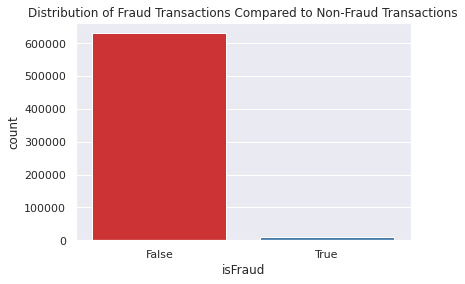

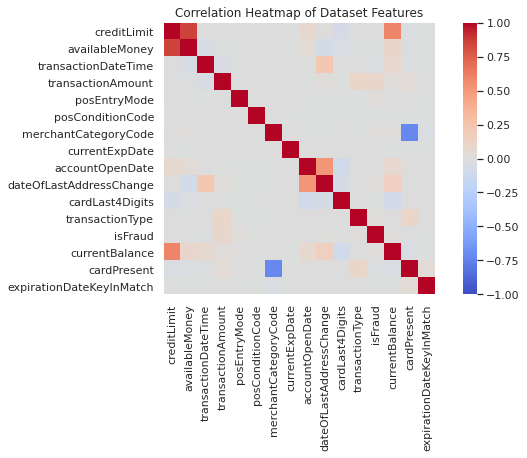

In [ ]:
# Ratio of fraudulent to non-fraudulent transactions
sns.set_theme(style = "darkgrid")
sns.countplot(data = enc_df, 
              x = "isFraud", 
              palette = "Set1")
plt.title("Distribution of Fraud Transactions Compared to Non-Fraud Transactions")
plt.xticks(rotation = 0)
plt.show()

# Correlation heatmap
plt.figure(figsize = (10, 5)) 
sns.heatmap(enc_df.corr(), 
            vmin = -1, 
            square = True,
            cmap = "coolwarm") 
plt.title("Correlation Heatmap of Dataset Features")
plt.show()

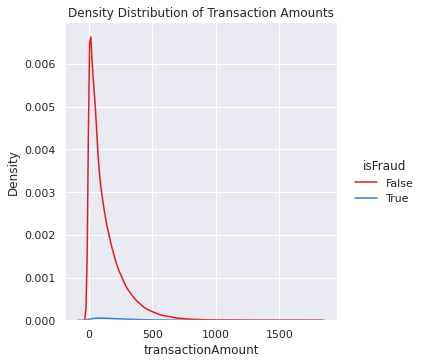

In [ ]:
# KDE plot of transaction amounts
sns.displot(data = enc_df,
            x = "transactionAmount",
            hue = "isFraud",
            kind = 'kde',
            palette = "Set1")
plt.title("Density Distribution of Transaction Amounts")
plt.xticks(rotation = 0)
plt.show()

# **Modeling and Cross Validation**

The three machine learning algorithms I used were the AdaBoost Classifier, Random Forest Classifier, and LightGBM Classifier. The data is split into 80% train data and 20% test data. The train data is then cross-validated using 5-fold  cross validation.

I encountered exceptionally long computation times at first and had to pull out some tricks like random under-sampling and SMOTE. I also experimented with rescaling and principal component analysis but the models did not seem to benefit from these techniques. By resampling the dataset I was able to nearly halve the time it took to fit the models.

In [ ]:
# Instantiates data and target variables
X = enc_df.drop("isFraud", axis = 1).values
y = enc_df["isFraud"].values

# Splits data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    train_size = 0.80, 
                                                    test_size = 0.20, 
                                                    random_state = 1)

# Cross-validation and hyperparameter tuning for models
oversampler = SMOTE(sampling_strategy = 0.1)
undersampler = RandomUnderSampler(sampling_strategy = 0.5)

scoring = {'AUC': 'roc_auc', 
           'F1': 'f1'}

abc = AdaBoostClassifier()
abc_params = {'model__n_estimators': [100, 200],
              'model__learning_rate': [.1, 1]}
balanced_abc = Pipeline([('over', oversampler),
                         ('under', undersampler),
                         ('model', abc)])

clf1 = GridSearchCV(balanced_abc, 
                    abc_params, 
                    cv = 5, 
                    n_jobs = -1,
                    verbose = 0, 
                    scoring = scoring,
                    refit = 'AUC')

clf1.fit(X_train, y_train)

lgbm = LGBMClassifier()
lgbm_params = {'model__n_estimators': [100, 200],
               'model__objective': ['binary'],
               'model__learning_rate': [.05, .1, .2],
               'model__max_depth': [-1, 5, 7, 10],
               'model__class_weight': ['None', 'balanced']}
balanced_lgbm = Pipeline([('over', oversampler),
                         ('under', undersampler),
                         ('model', lgbm)])

clf2 = RandomizedSearchCV(balanced_lgbm,
                          lgbm_params,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 0,
                          scoring = scoring,
                          refit = 'AUC')
clf2.fit(X_train, y_train)


rfc = RandomForestClassifier()
rfc_params = {'model__n_estimators': [100, 200],
              'model__max_depth': [-1, 5, 7, 10],
              'model__class_weight': ['None', 'balanced']}
balanced_rfc = Pipeline([('over', oversampler),
                         ('under', undersampler),
                         ('model', rfc)])
                         
clf3 = RandomizedSearchCV(balanced_rfc,
                          rfc_params,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 0,
                          scoring = scoring,
                          refit = 'AUC')

clf3.fit(X_train, y_train)

print()
print("Best hyperparameters for the AdaBoost classifier: ", clf1.best_params_)
print("Best score for the AdaBoost classifier: ", clf1.best_score_)
print()
print("Best hyperparameters for the LGBM classifier: ", clf2.best_params_)
print("Best score for the LGBM classifier: ", clf2.best_score_)
print()
print("Best hyperparameters for the Random Forest classifier: ", clf3.best_params_)
print("Best score for the Random Forest classifier: ", clf3.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni


Best hyperparameters for the AdaBoost classifier:  {'model__learning_rate': 1, 'model__n_estimators': 200}
Best score for the AdaBoost classifier:  0.7222608919588075

Best hyperparameters for the LGBM classifier:  {'model__objective': 'binary', 'model__n_estimators': 200, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__class_weight': 'balanced'}
Best score for the LGBM classifier:  0.7821919326713729

Best hyperparameters for the Random Forest classifier:  {'model__n_estimators': 200, 'model__max_depth': 7, 'model__class_weight': 'balanced'}
Best score for the Random Forest classifier:  0.7203977843809427


# **Evaluation**

**Predicticting Fraudulent Activity**

In [ ]:
# Predictions
abc_eval_predicted = clf1.best_estimator_.predict(X_test)
lgbm_eval_predicted = clf2.best_estimator_.predict(X_test)
rfc_eval_predicted = clf3.best_estimator_.predict(X_test)

# Generates F1 scores for the models
abc_f1_score = f1_score(y_test, abc_eval_predicted)
lgbm_f1_score = f1_score(y_test, lgbm_eval_predicted)
rfc_f1_score = f1_score(y_test, rfc_eval_predicted)

# Generates AUROC scores for the models
abc_roc_score = roc_auc_score(y_test, abc_eval_predicted)
lgbm_roc_score = roc_auc_score(y_test, lgbm_eval_predicted)
rfc_roc_score = roc_auc_score(y_test, rfc_eval_predicted)

# Generates ROC curves for the models
abc_fpr, abc_tpr, abc_ = roc_curve(y_test, abc_eval_predicted)
lgbm_fpr, lgbm_tpr, lgbm_ = roc_curve(y_test, lgbm_eval_predicted)
rfc_fpr, rfc_tpr, rfc_  = roc_curve(y_test, rfc_eval_predicted)

**Performance Summary**

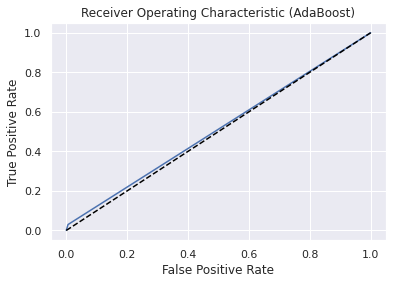

In [ ]:
# Plots ROC curves
plt.plot(abc_fpr, abc_tpr)
plt.plot((0,1), ls = 'dashed', color = 'black')
plt.title('Receiver Operating Characteristic (AdaBoost)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

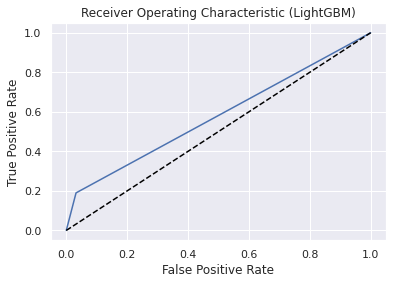

In [ ]:
plt.plot(lgbm_fpr, lgbm_tpr)
plt.plot((0,1), ls = 'dashed', color = 'black')
plt.title('Receiver Operating Characteristic (LightGBM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

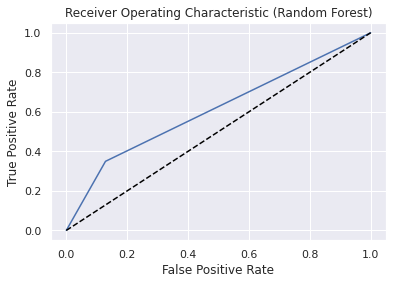

In [ ]:
plt.plot(rfc_fpr, rfc_tpr)
plt.plot((0,1), ls = 'dashed', color = 'black')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# Summarizes scores in table
scores = {'AUROC Score': [abc_roc_score, lgbm_roc_score, rfc_roc_score],
          'F1 Score': [abc_f1_score, lgbm_f1_score, rfc_f1_score]}

scores_df = pd.DataFrame(data = scores, index = ['AdaBoost', 
                                                 'LightGBM', 
                                                 'Random Forest'])
scores_df

,AUROC Score,F1 Score
AdaBoost,0.512008,0.044387
LightGBM,0.578912,0.129706
Random Forest,0.610364,0.083824


**Results**

As shown by the ROC curves, AUROC scores, and F1 scores, all models performed pretty poorly and suffer from overfitting. This can be due to poor hyperparameter tuning, data preprocessing techniques, resampling techniques, or a combination of the three.

Using AUROC score as the primary indicator of performance, then the Random Forest classifier is the best method. Using F1 score, then LightGBM is the best method. Overall, I think the Random Forest classifier is the best method as it was the least overfit out of the three models.

# **References**

“AdaBoost Classifier in Python.” DataCamp Community, www.datacamp.com/community/tutorials/adaboost-classifier-python. 

Brownlee, Jason. “SMOTE for Imbalanced Classification with Python.” Machine Learning Mastery, 20 Aug. 2020, machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/. 

“LightGBM Classifier in Python.” Kaggle, Kaggle, 21 July 2020, www.kaggle.com/prashant111/lightgbm-classifier-in-python.

Moffitt, Chris. “Guide to Encoding Categorical Values in Python.” Practical Business Python Atom, 6 Feb. 2017, pbpython.com/categorical-encoding.html. 

Mujtaba, Hussain. “An Introduction to Grid Search CV: What Is Grid Search.” GreatLearning, 6 Oct. 2020, www.mygreatlearning.com/blog/gridsearchcv/. 

“Random Forests Classifiers in Python.” DataCamp Community, www.datacamp.com/community/tutorials/random-forests-classifier-python. 

VanderPlas, Jake. “Visualization with Seaborn.” Visualization with Seaborn | Python Data Science Handbook, jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html. 

Worcester, Peter. “A Comparison of Grid Search and Randomized Search Using Scikit Learn.” Medium, Noteworthy - The Journal Blog, 6 June 2019, blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85. 

